In [1]:
import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

from model import build_encoder, build_autoencoder
from data import example_to_tensor, normalize, add_channel_axis, train_test_split
from train import train_func
from utils import duplicate_iterator, plot_slice, plot_animated_volume
from config import allocate_gpu_memory_only_when_needed, data_root_dir, seed

%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 7]

In [2]:
allocate_gpu_memory_only_when_needed(True)
input_shape = (24, 128, 128, 1)
total_samples = 200
epochs = 1000
batch_size = 4
learning_rate = 0.0001
val_perc = 0.1  # percentage from the already splitted training test
test_perc = 0.1

In [3]:
neg_tfrecord_fnames = [
    str(p) for p in Path(data_root_dir).glob("covid-neg-0.25/*.tfrecord")
]
neg_x = (
    tf.data.TFRecordDataset(neg_tfrecord_fnames)
    .map(example_to_tensor, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .map(add_channel_axis, num_parallel_calls=tf.data.experimental.AUTOTUNE)
)
neg_x

<ParallelMapDataset shapes: (None, None, None, 1), types: tf.float32>

In [4]:
pos_tfrecord_fnames = [
    str(p) for p in Path(data_root_dir).glob("covid-pos-0.25/*.tfrecord")
]
pos_x = (
    tf.data.TFRecordDataset(pos_tfrecord_fnames)
    .map(example_to_tensor, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .map(add_channel_axis, num_parallel_calls=tf.data.experimental.AUTOTUNE)
)
pos_x

<ParallelMapDataset shapes: (None, None, None, 1), types: tf.float32>

In [5]:
unsupervised_train_ds, unsupervised_val_ds = train_test_split(
    neg_x.concatenate(pos_x),
    test_perc=test_perc,
    cardinality=total_samples,
    seed=seed,
)
unsupervised_val_ds = unsupervised_val_ds.padded_batch(batch_size, input_shape)
val_ds_gen = duplicate_iterator(unsupervised_val_ds)
unsupervised_val_ds = (
    tf.data.Dataset.from_generator(lambda: val_ds_gen, (tf.float32, tf.float32))
    .cache()
    .prefetch(tf.data.experimental.AUTOTUNE)
)
unsupervised_train_ds = unsupervised_train_ds.padded_batch(batch_size, input_shape)
train_ds_gen = duplicate_iterator(unsupervised_train_ds)
unsupervised_train_ds = (
    tf.data.Dataset.from_generator(lambda: train_ds_gen, (tf.float32, tf.float32))
    .cache()  # must be called before shuffle
    .shuffle(buffer_size=64, reshuffle_each_iteration=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)
unsupervised_train_ds

<PrefetchDataset shapes: (<unknown>, <unknown>), types: (tf.float32, tf.float32)>

In [6]:
autoencoder = build_autoencoder(input_shape)
autoencoder.get_layer("encoder").summary()
autoencoder.get_layer("decoder").summary()
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 24, 128, 128, 1)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 24, 128, 128, 32)  896       
_________________________________________________________________
alpha_dropout (AlphaDropout) (None, 24, 128, 128, 32)  0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 12, 64, 64, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 12, 64, 64, 64)    55360     
_________________________________________________________________
alpha_dropout_1 (AlphaDropou (None, 12, 64, 64, 64)    0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 6, 32, 32, 64)     0   

In [7]:
autoencoder = train_func(
    autoencoder,
    keras.optimizers.Adam(learning_rate),
    keras.losses.MeanSquaredError(),
    unsupervised_train_ds,
    unsupervised_val_ds,
    model_dir="models/autoencoder/",
    logs_dir="logs/autoencoder",
    monitor_metric="val_loss",
)

Epoch 1/1000
45/45 [==============================] - 10s 224ms/step - loss: 0.0546 - val_loss: 0.0510
Epoch 2/1000
45/45 [==============================] - 10s 213ms/step - loss: 0.0212 - val_loss: 0.0293
Epoch 3/1000
45/45 [==============================] - 10s 214ms/step - loss: 0.0168 - val_loss: 0.0206
Epoch 4/1000
45/45 [==============================] - 10s 214ms/step - loss: 0.0143 - val_loss: 0.0195
Epoch 5/1000
45/45 [==============================] - 10s 214ms/step - loss: 0.0129 - val_loss: 0.0167
Epoch 6/1000
45/45 [==============================] - 10s 215ms/step - loss: 0.0119 - val_loss: 0.0152
Epoch 7/1000
45/45 [==============================] - 10s 215ms/step - loss: 0.0110 - val_loss: 0.0142
Epoch 8/1000
45/45 [==============================] - 10s 215ms/step - loss: 0.0104 - val_loss: 0.0131
Epoch 9/1000
45/45 [==============================] - 9s 190ms/step - loss: 0.0099 - val_loss: 0.0141


In [9]:
original, _ = next(iter(unsupervised_val_ds))
encoder_out = autoencoder.get_layer("encoder")(original, training=False)
decoder_out = autoencoder.get_layer("decoder")(encoder_out, training=False)
batch_index = 0

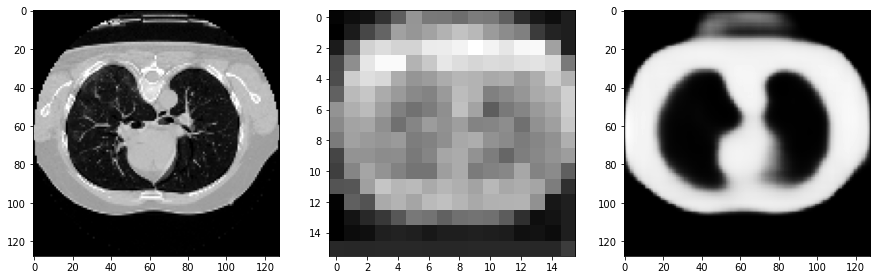

In [10]:
z_index = 5
fig, ax = plt.subplots(ncols=3)
plot_slice(original[batch_index, :], z_index, ax[0])
plot_slice(encoder_out[batch_index, :], encoder_out.shape[1] // 3, ax[1])
plot_slice(decoder_out[batch_index, :], z_index, ax[2])

In [11]:
num_neg = sum(1 for _ in neg_x)
neg_y = tf.data.Dataset.from_tensors(tf.constant([0], dtype=tf.int8)).repeat(num_neg)
neg_dataset = tf.data.Dataset.zip((neg_x, neg_y))
neg_dataset

<ZipDataset shapes: ((None, None, None, 1), (1,)), types: (tf.float32, tf.int8)>

In [12]:
num_pos = sum(1 for _ in pos_x)
pos_y = tf.data.Dataset.from_tensors(tf.constant([1], dtype=tf.int8)).repeat(num_pos)
pos_dataset = tf.data.Dataset.zip((pos_x, pos_y))
pos_dataset

<ZipDataset shapes: ((None, None, None, 1), (1,)), types: (tf.float32, tf.int8)>

In [13]:
dataset = neg_dataset.concatenate(pos_dataset)
dataset, test_dataset = train_test_split(
    dataset,
    test_perc=test_perc,
    cardinality=total_samples,
    seed=seed,
)
test_dataset = test_dataset.padded_batch(1, (input_shape, (1,)))
train_dataset, val_dataset = train_test_split(
    dataset,
    test_perc=val_perc,
    cardinality=None,
    seed=seed,
)
val_dataset = (
    val_dataset.padded_batch(batch_size, (input_shape, (1,)), drop_remainder=True)
    .cache()
    .prefetch(tf.data.experimental.AUTOTUNE)
)
train_dataset = (
    train_dataset.padded_batch(batch_size, (input_shape, (1,)), drop_remainder=True)
    .cache()  # must be called before shuffle
    .shuffle(buffer_size=64, reshuffle_each_iteration=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)
train_dataset

<PrefetchDataset shapes: ((4, 24, 128, 128, 1), (4, 1)), types: (tf.float32, tf.int8)>

In [36]:
# Use pre-trained encoder
encoder = keras.models.load_model("models/autoencoder/20201019-111556.h5").get_layer(
    "encoder"
)
# encoder = build_encoder(input_shape)
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 24, 128, 128, 1)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 24, 128, 128, 32)  896       
_________________________________________________________________
alpha_dropout (AlphaDropout) (None, 24, 128, 128, 32)  0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 12, 64, 64, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 12, 64, 64, 64)    55360     
_________________________________________________________________
alpha_dropout_1 (AlphaDropou (None, 12, 64, 64, 64)    0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 6, 32, 32, 64)     0   

In [37]:
cnn = keras.Sequential(
    [
        encoder,
        keras.layers.Flatten(),
        keras.layers.Dense(
            512,
            kernel_initializer="lecun_normal",
            bias_initializer="lecun_normal",
            activation="selu",
        ),
        keras.layers.AlphaDropout(0.1),
        keras.layers.Dense(1, activation="sigmoid"),
    ],
    "cnn",
)
cnn.summary()

Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Functional)         (None, 3, 16, 16, 128)    277568    
_________________________________________________________________
flatten_3 (Flatten)          (None, 98304)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               50332160  
_________________________________________________________________
alpha_dropout_12 (AlphaDropo (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 513       
Total params: 50,610,241
Trainable params: 50,610,241
Non-trainable params: 0
_________________________________________________________________


In [38]:
cnn = train_func(
    cnn,
    keras.optimizers.Adam(learning_rate),
    keras.losses.BinaryCrossentropy(),
    train_dataset,
    val_dataset,
    model_dir="models",
    logs_dir="logs",
    monitor_metric="val_acc",
    metrics=["acc"],
)

Epoch 1/1000
      2/Unknown - 0s 26ms/step - loss: 23.3379 - acc: 0.7500WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0039s vs `on_train_batch_end` time: 0.0485s). Check your callbacks.
     39/Unknown - 2s 47ms/step - loss: 2.3037 - acc: 0.5192WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0027s vs `on_test_batch_end` time: 0.0071s). Check your callbacks.
40/40 [==============================] - 60s 1s/step - loss: 2.2634 - acc: 0.5188 - val_loss: 0.6989 - val_acc: 0.3750
Epoch 2/1000
40/40 [==============================] - 60s 2s/step - loss: 0.7054 - acc: 0.4563 - val_loss: 0.6937 - val_acc: 0.3750


In [39]:
cnn.evaluate(test_dataset, verbose=0, return_dict=True)

{'loss': 0.6933821439743042, 'acc': 0.44999998807907104}

real: [[0]], prediction: [[0.49885294]]


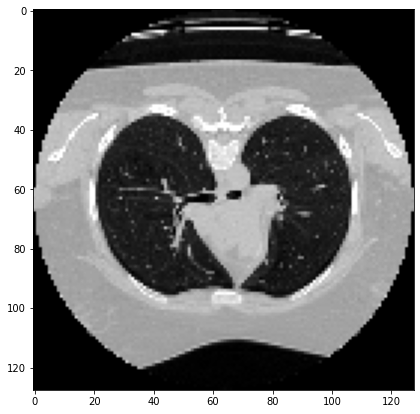

In [42]:
x, y = next(iter(test_dataset.skip(4)))
plot_slice(x[0, :], z_index=5)
prediction = cnn(x, training=False)
print(f"real: {y.numpy()}, prediction: {prediction.numpy()}")